In [6]:
import math
import numpy as np
import pandas as pd
from decimal import Decimal
import matplotlib.pyplot as plt

# Implementar

### Log

In [13]:
def log_results(filename, poblacion_final):
    poblacion_final = poblacion_final.sort_values('apt')
    # Guardar población
    poblacion_final.to_csv(f'log/poblaciones/pop_{filename}.csv')

    # Estadísticos
    sol_min = poblacion_final.iloc[0]
    sol_max = poblacion_final.iloc[-1]
    apt_media = poblacion_final['apt'].mean()
    apt_std = poblacion_final['apt'].std()

    pop_stats = pd.Series({'min_crom': sol_min['cromosoma'], 'min_apt': sol_min['apt'],
                           'max_crom': sol_max['cromosoma'], 'max_apt': sol_max['apt'],
                           'media_apt': apt_media, 'std_apt': apt_std})
    pop_stats.to_csv(f'log/estadisticas/stats_{filename}.csv')


In [81]:
def parent_df(fathers, mothers):
    '''
    Crea un DataFrame agrupando los individuos en Padres y Madres.
    '''
    fathers = fathers.reset_index()
    mothers = mothers.reset_index()
    col_groups = pd.MultiIndex.from_arrays([['Padres']*3 + ['Madres']*3, fathers.columns.tolist() + mothers.columns.tolist()])

    # Concatenar los DataFrames horizontalmente
    padres_df = pd.concat([fathers, mothers], axis=1)
    padres_df.columns = col_groups
    return padres_df


In [ ]:
def log_generacion(filename, mode='save', **kwargs):
    if mode=='save':
        gener_elements = {'Poblacion', 'Nueva poblacion', 'Padres': parent_df, 'Hijos', 'Puntos cruza', 'Valores de mutacion', 'Mejor individuo'}
        # df(N,2), df(N,2), tuple (N//2,2), [df(N), Series(N//2), Series(N)], dataframe(1,2)
        # Convertir padres a dataframe agrupado por columnas
        # Unir Hijos | Puntos cruza | Valores de mutacion
        # Crear un Dataframe con todo eso
        # Pasar todo a to_string()
        # Guardar to csv

        # Padres
        kwargs['Padres'] = parent_df(*kwargs['Padres'])

        # Hijos
        hijos = kwargs.pop('Hijos')
        hijos = hijos.reshape(2,hijos.shape[0]//2) # Forma de hermanos
        hijos_df = pd.DataFrame(hijos).T

        # Puntos cruza, info de padres y valores de mutación
        puntos_cruza = kwargs.pop('Puntos cruza')
        val_mut = kwargs.pop('Valores de mutacion')
        val_mut = val_mut.reshape(val_mut.shape[0]//2, 2) # Forma de hermanos

        kwargs['Hijos'] = hijos_df.assign({'Punto cruza':puntos_cruza,
                                           'P':kwargs['Padres']['index'], 'M':kwargs['Madres']['index'],
                                           'Valores mutación 0':val_mut[0], 'Valores mutación 1':val_mut[1]})
        
        # Convertir a texto para su impresión y guardar
        pd.DataFrame(kwargs).apply(lambda df: df.to_string()).to_csv(f'log/generaciones/gen_{filename}.csv')
        pass
    
    elif mode=='load':
        return pd.read_csv(filename)


In [330]:
# Definición de genes
Gen1 = Gen((-500,500),1)
Gen2 = Gen((-500,500),1)
CromA = Cromosoma(Gen1,Gen2)

In [331]:
# Algoritmo
se = SimpleEvolutionary(Gen1,Gen2)

In [332]:
# Crear población inicial
N=10
size = CromA.crom_len
se.f = f
pop = se.random_generator(N=N,size=size)
se.poblacion = pop
pop

,cromosoma,apt
0,0000001100000000000100111110,819.049739
1,0000000011010110101101001011,575.923051
2,1100011110110000111100010011,938.351678
3,0110110101100101010001110101,1031.620551
4,1101001110000001111111100010,1071.102413
5,1111011111100011111111100000,836.981280
6,0111111101001010110110011001,648.510634
7,1111111011111111000100110110,1147.995561
8,1000001110111010000001011010,843.207808
9,1000110110011100011000010000,1181.470086


In [333]:
# Selección de padres
par_sel = se.ruleta()
par_sel

,cromosoma,apt
2,1100011110110000111100010011,938.351678
5,1111011111100011111111100000,836.981280
7,1111111011111111000100110110,1147.995561
7,1111111011111111000100110110,1147.995561
1,0000000011010110101101001011,575.923051
7,1111111011111111000100110110,1147.995561
9,1000110110011100011000010000,1181.470086
9,1000110110011100011000010000,1181.470086
8,1000001110111010000001011010,843.207808
9,1000110110011100011000010000,1181.470086


In [334]:
fathers = par_sel.iloc[::2]
fathers

,cromosoma,apt
2,1100011110110000111100010011,938.351678
7,1111111011111111000100110110,1147.995561
1,0000000011010110101101001011,575.923051
9,1000110110011100011000010000,1181.470086
8,1000001110111010000001011010,843.207808


In [335]:
mothers = par_sel.iloc[1::2]
mothers

,cromosoma,apt
5,1111011111100011111111100000,836.981280
7,1111111011111111000100110110,1147.995561
7,1111111011111111000100110110,1147.995561
9,1000110110011100011000010000,1181.470086
9,1000110110011100011000010000,1181.470086


In [336]:
# Cruza
recombinacion = np.array(np.vectorize(se.cruza)
                         (fathers['cromosoma'], mothers['cromosoma'])
                         )
recombinacion

array([['1111011111100011111111100000', '1111111011111111000100110110',
        '0111111011111111000100110110', '1000110110011100011000010000',
        '1000001110111100011000010000'],
       ['1100011110110000111100010011', '1111111011111111000100110110',
        '1000000011010110101101001011', '1000110110011100011000010000',
        '1000110110011010000001011010'],
       ['2', '1', '1', 'None', '13']], dtype='<U28')

In [337]:
cruza = recombinacion[[0,1],:].reshape(-1)
puntos_cruza = recombinacion[-1,:]
cruza

array(['1111011111100011111111100000', '1111111011111111000100110110',
       '0111111011111111000100110110', '1000110110011100011000010000',
       '1000001110111100011000010000', '1100011110110000111100010011',
       '1111111011111111000100110110', '1000000011010110101101001011',
       '1000110110011100011000010000', '1000110110011010000001011010'],
      dtype='<U28')

In [338]:
puntos_cruza

array(['2', '1', '1', 'None', '13'], dtype='<U28')

---

In [361]:
# Mutación
n_muts, mutacion,flips = np.vectorize(se.mutacion)(cruza.reshape(-1))

In [362]:
mutacion

array(['1111011111100011111111100000', '1111111011111001000100111110',
       '0111111011111111000000110110', '1000110110011100011000010000',
       '1000001110111000011000010000', '0100011110110000111100010011',
       '1111111010111111000100110110', '1000000011010110000101001011',
       '1000110110011100011000010000', '1000110110011010000001011010'],
      dtype='<U28')

In [383]:
pd.DataFrame(mutacion)

,0
0,1111011111100011111111100000
1,1111111011111001000100111110
2,0111111011111111000000110110
3,1000110110011100011000010000
4,1000001110111000011000010000
5,0100011110110000111100010011
6,1111111010111111000100110110
7,1000000011010110000101001011
8,1000110110011100011000010000
9,1000110110011010000001011010


In [385]:
pd.DataFrame(mutacion.reshape(mutacion.shape[0]//2,2))

,0,1
0,1111011111100011111111100000,1111111011111001000100111110
1,0111111011111111000000110110,1000110110011100011000010000
2,1000001110111000011000010000,0100011110110000111100010011
3,1111111010111111000100110110,1000000011010110000101001011
4,1000110110011100011000010000,1000110110011010000001011010


In [364]:
flips

array(['[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]',
       '[0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 1 0 0 0]',
       '[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0]',
       '[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]',
       '[0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0]',
       '[1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]',
       '[0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]',
       '[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 0 0 0 0 0 0 0 0 0]',
       '[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]',
       '[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]'],
      dtype='<U57')

In [375]:
pd.DataFrame(np.concatenate([mutacion, flips]).reshape(4,5), index=[0,1,'flip 0','flip 1']).T

,0,1,flip 0,flip 1
0,1111011111100011111111100000,0100011110110000111100010011,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0...,[1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0...
1,1111111011111001000100111110,1111111010111111000100110110,[0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0...,[0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0...
2,0111111011111111000000110110,1000000011010110000101001011,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0...,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 0 0 0 0...
3,1000110110011100011000010000,1000110110011100011000010000,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0...,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0...
4,1000001110111000011000010000,1000110110011010000001011010,[0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0...,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0...


---

In [339]:
############# Esto buscamos
hijos_redf = pd.DataFrame(cruza.reshape(2,cruza.shape[0]//2)).T
hijos_redf

,0,1
0,1111011111100011111111100000,1100011110110000111100010011
1,1111111011111111000100110110,1111111011111111000100110110
2,0111111011111111000100110110,1000000011010110101101001011
3,1000110110011100011000010000,1000110110011100011000010000
4,1000001110111100011000010000,1000110110011010000001011010


In [340]:
hijos_pcruza_redf = pd.DataFrame(recombinacion).T
hijos_pcruza_redf = hijos_pcruza_redf.rename({2: 'Punto cruza'}, axis = 1)
hijos_pcruza_redf

,0,1,Punto cruza
0,1111011111100011111111100000,1100011110110000111100010011,2
1,1111111011111111000100110110,1111111011111111000100110110,1
2,0111111011111111000100110110,1000000011010110101101001011,1
3,1000110110011100011000010000,1000110110011100011000010000,None
4,1000001110111100011000010000,1000110110011010000001011010,13


In [341]:
'1010111010110110100100011101010011' == '1010111010110110100100011101010011'

True

In [342]:
padres_df = parent_df(fathers, mothers)
padres_df

Padres                                            Madres  \
   index                     cromosoma          apt  index   
0      2  1100011110110000111100010011   938.351678      5   
1      7  1111111011111111000100110110  1147.995561      7   
2      1  0000000011010110101101001011   575.923051      7   
3      9  1000110110011100011000010000  1181.470086      9   
4      8  1000001110111010000001011010   843.207808      9   

                                              
                      cromosoma          apt  
0  1111011111100011111111100000   836.981280  
1  1111111011111111000100110110  1147.995561  
2  1111111011111111000100110110  1147.995561  
3  1000110110011100011000010000  1181.470086  
4  1000110110011100011000010000  1181.470086

In [343]:
# Opt2
hijos_info = hijos_pcruza_redf.assign(P=padres_df['Padres']['index'],M=padres_df['Madres']['index'])
hijos_info

,0,1,Punto cruza,P,M
0,1111011111100011111111100000,1100011110110000111100010011,2,2,5
1,1111111011111111000100110110,1111111011111111000100110110,1,7,7
2,0111111011111111000100110110,1000000011010110101101001011,1,1,7
3,1000110110011100011000010000,1000110110011100011000010000,None,9,9
4,1000001110111100011000010000,1000110110011010000001011010,13,8,9


In [344]:
# Mutación
n_muts, mutacion,flips = np.vectorize(se.mutacion)(cruza.reshape(-1))

In [345]:
mutacion.reshape(2,mutacion.shape[0]//2)

array([['1111011111100011111111100000', '1111111011111110000100110110',
        '0111111011111111000100110110', '1000110110011100011000011001',
        '1001001110111100011000010000'],
       ['1100011110110100111100010011', '1111111011011110000100110110',
        '1000000011110110101011001011', '1000110110011100011001010000',
        '1000110110011010000001011010']], dtype='<U28')

In [360]:
####### HIJOS dim=N
pd.DataFrame(mutacion).assign()

,0
0,1111011111100011111111100000
1,1111111011111110000100110110
2,0111111011111111000100110110
3,1000110110011100011000011001
4,1001001110111100011000010000
5,1100011110110100111100010011
6,1111111011011110000100110110
7,1000000011110110101011001011
8,1000110110011100011001010000
9,1000110110011010000001011010


In [347]:
hijos_info[['Valores mutacion 0','Valores mutacion 1']] = pd.DataFrame(flips.reshape(2,flips.shape[0]//2)).T
hijos_info

,0,1,Punto cruza,P,M,Valores mutacion 0,Valores mutacion 1
0,1111011111100011111111100000,1100011110110000111100010011,2,2,5,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0...,[0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0...
1,1111111011111111000100110110,1111111011111111000100110110,1,7,7,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0...,[0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 1 0 0 0 0 0 0 0...
2,0111111011111111000100110110,1000000011010110101101001011,1,1,7,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0...,[0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 1 1 0 0...
3,1000110110011100011000010000,1000110110011100011000010000,None,9,9,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0...,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0...
4,1000001110111100011000010000,1000110110011010000001011010,13,8,9,[0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0...,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0...


In [348]:
print(hijos_info.to_string())

                              0                             1 Punto cruza  P  M                                         Valores mutacion 0                                         Valores mutacion 1
0  1111011111100011111111100000  1100011110110000111100010011           2  2  5  [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]  [0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
1  1111111011111111000100110110  1111111011111111000100110110           1  7  7  [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0]  [0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0]
2  0111111011111111000100110110  1000000011010110101101001011           1  1  7  [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]  [0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0]
3  1000110110011100011000010000  1000110110011100011000010000        None  9  9  [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1]  [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0]
4  1000001

In [353]:
pd.DataFrame(mutacion.reshape(2,mutacion.shape[0]//2)).T

,0,1
0,1111011111100011111111100000,1100011110110100111100010011
1,1111111011111110000100110110,1111111011011110000100110110
2,0111111011111111000100110110,1000000011110110101011001011
3,1000110110011100011000011001,1000110110011100011001010000
4,1001001110111100011000010000,1000110110011010000001011010


In [354]:
print(padres_df['Padres']['cromosoma'].loc[2])
print(pd.DataFrame(mutacion.reshape(2,mutacion.shape[0]//2)).T[1].loc[2])

0000000011010110101101001011
1000000011110110101011001011


In [352]:
hijos_info[1].loc[0] == padres_df['Padres']['cromosoma'].loc[0]

True

### Estructura cromosómica

In [13]:
class Gen:
    """
    Clase que representa la estructura y funcionamiento de un gen. No representa a un Gen.

    ...

    Attributes
    ----------
    dominio : tuple
        Dominio de valores reales del gen [x,y]
    precision : int
        Número de decimales que puede adquirir el valor real del Gen.
    len : int
        Longitud del Gen en su expresión binaria.
    norm : Decimal
        Constante de normalización del rango de valores binarios posibles del Gen al Dominio de sus valores reales.
    offset : Decimal
        Desplazamiento del Dominio expresado en valores enteros (sin punto decimal) a la región > 0.

    Methods
    -------
    translate(x,mode='decode')
        Traduce entre representación binaria de un Gen <-> expresión real
    """

    def __init__(self,dominio,precision):
        """
        Parameters
        ----------
        dominio : tuple
            Límites (liminf, limsup) de la variable en cuestión.
        precision : int
            Número de cifras decimales luego del punto para la variable en cuestión. Debe ser mayor al máximo número de decimales en el dominio
        """       
        self.dominio = dominio
        self.precision = precision
        self.len = self._length()

        # Offset lb -> all(0) ; ub -> all(1)
        self.norm = (Decimal(str(dominio[1])) - Decimal(str(dominio[0]))) *10**precision / int('1'*self.len,2)
        self.offset = Decimal(str(dominio[0])) #* 10**precision

    
    def _length(self):
        """Calcula el número de bits en un gen.

        Returns
        -------
        int
            Número de bits del gen <-> variable.
        """
        # Limites
        rango = self.dominio[1] - self.dominio[0]
        cell_count = math.ceil(np.log2(rango))

        # Decimales
        cell_count += math.ceil(np.log2(10**self.precision - 1))
        return cell_count
    
    def translate(self,x,mode='decode'):
        '''
        Traductor para codificar/decodificar (reales <-> binario) genes. 

        Parameters
        ----------
        x : float or str
            Gen a traducir (float si es un real, str si es binario).
        mode : str (code,decode)
            Uno de dos modos: 'code' para pasar de número real a binario, y 'decode' para pasar de binario a real.

        Returns
        -------
        str or float
            Gen traducido (str si x era un float, float si x era binario).
        '''
        
        if mode == 'code':
            ## Real -> Binario
            
            # Cortar decimales por redondeo
            x = float(x) # failsafe
            x = round(x,self.precision) - self.offset # precision y offset

            # Eliminar punto
            x_int,x_dec = str(x).split(".")
            x_dec = x_dec.ljust(self.precision,"0") # Rellena decimales de precision

            # Representación entera
            x_rep = int(x_int + x_dec)

            # Offset -> ran >= 0
            x_rep = Decimal(str(x_rep)) / self.norm
            x_rep = round(x_rep) # Nuevos decimales son de orden mayor a la precision
            return np.binary_repr(x_rep, width=self.len)
        
        elif mode == 'decode':
            ## Binario -> Real

            # Convierte a entero base 10
            x_rep = int(x,2)

            # Extraer Normalización
            x_rep = round(x_rep * self.norm)  # Nuevos decimales son de orden mayor a la precision + self.offset
            
            # Añadir el punto decimal
            x_rep = str(x_rep).zfill(self.precision) # Rellena decimales de precision
            int_part = x_rep[:-self.precision]
            dec_part = x_rep[-self.precision:]
            x_float = Decimal(int_part + '.' + dec_part)
            
            # Regresar offset
            x_float = x_float + self.offset 
            return float(x_float)

In [14]:
class Cromosoma:
    """
    Clase que representa la estructura y funcionamiento de un Cromosoma. No representa a un Cromosoma.

    ...

    Attributes
    ----------
    genes : tuple
        Tupla de objetos Gen en el Cromosoma, ordenados según el locus del gen.
    cromosoma : str
        Expresión binaria del cromosoma (genotipo). Es calculada sólo mediante el método "genotipo".
    crom_len : int
        Longitud del Cromosoma en su expresión binaria.

    Methods
    -------
    genotipo(x,mode='decode')
        Traduce entre representación binaria de un Cromosoma <-> expresión real de sus Genes.
    """

    def __init__(self,*genes):
        """
        Parameters
        ----------
        genes : Gen
            Gen(es) del cromosoma ordenado(s)
        """       
        
        self.genes = genes
        self.cromosoma = None
        self.crom_len = sum([gen.len for gen in genes])
        
    def genotipo(self,x,mode='decode'):
        '''
        Traductor para codificar/decodificar (reales <-> binario) cromosomas a través de sus genes.

        Parameters
        ----------
        x : list o str
            Expresión del cromosoma (lista si los genes se expresan en números reales, str si el cromosoma es binario)
        mode : str (code,decode)
            Uno de dos modos: 'code' para pasar de número real a binario, y 'decode' para pasar de binario a real.

        Returns
        -------
        str o list
            Cromosoma traducido (elementos tipo str si "genes" era una lista, lista si "genes" era binario).
        '''

        if mode == 'code':
            ## Real -> Binario
            genes_bin = [gen.translate(val, mode=mode) for val,gen in zip(x,self.genes)]
            self.cromosoma = ''.join(genes_bin)
            return self.cromosoma
        
        elif mode == 'decode':
            ## Binario -> Real
            genes_lens = [gen.len for gen in self.genes]
            ind_final = np.cumsum(genes_lens)
            genes_r = [gen.translate(x[ind-lens:ind]) for gen, lens, ind in zip(self.genes, genes_lens, ind_final)]
            return genes_r

### Algoritmo

In [292]:
class SimpleEvolutionary(Cromosoma):
    """
    Clase del Algoritmo Evolutivo Simple que hereda una estructura Cromosoma para funcionar.

    ...
    Methods
    -------
    genotipo(x,mode='decode')
        Traduce entre representación binaria de un Cromosoma <-> expresión real de sus Genes.
    """

    def optimize(self,f,N,num_gener,fast=False,verbose=True,export_name='Run'):
        '''
        Rutina de maximización de una función "f". Imprimime la información de cada generación.

        Parameters
        ----------
        f : function
            Función a maximizar
        N : int
            Número de individuos en la población inicial.
        num_gener : int
            Número de generaciones esperadas.
        fast : bool, optional
            Trunca el algoritmo cuando el mejor individuo de la generación anterior es igual al mejor individuo 
            de la generación actual (default=False)
        verbose : bool, optional
            Imprime información de los individuos y procesos de cada generación. (default=True)
        export_name : str, optional
            Nombre del archivo de registro de finalización del algoritmo. (default='se')

        Returns
        -------
        Series
            Mejor individuo (cromosoma binario, aptitud) al cumplirse los criterios de la rutina.
        '''
        #%#%#%#%#% Inicializar
        self.f = f
        self.N = N
        self.mejor_individuo = None
        # Sólo poblaciones pares
        if N % 2 != 0: 
            self.N = N + 1
        # Genera población aleatoria
        self.poblacion = self.random_generator(self.N,self.crom_len)

        #%#%#%#%#% Rutina evolutiva
        for generacion in range(num_gener):
            # Selecciona padres
            par_selection = self.ruleta()
            # Cruza los padres 2 a 2
            mothers = par_selection.iloc[1::2]
            fathers = par_selection.iloc[::2]
            
            # Generación de hijos
            recombinacion = np.array(np.vectorize(self.cruza)
                                     (fathers['cromosoma'], mothers['cromosoma'])
                                     )
            cruza = recombinacion[[0,1],:].reshape(-1)
            puntos_cruza = recombinacion[-1,:]
            n_muts, mutacion, flips = np.vectorize(self.mutacion)(cruza)
            
            # Aptitud de hijos
            descendencia = pd.DataFrame([self.individuo(cromosoma[0]) for cromosoma in mutacion],
                                        columns = ['cromosoma','apt'])
            # Elitismo
            nueva_poblacion = self.sobrevivientes(descendencia)
            self.mejor_individuo = nueva_poblacion.iloc[np.argmax(nueva_poblacion['apt'])]
            self.poblacion = nueva_poblacion
            
            # Imprimir descripción de la generación
            if verbose:
                self._gen_descripcion(generacion, mothers, n_muts)
            if fast and (self.mejor_individuo['apt'] == self.poblacion['apt'].iloc[0]):
                break
                
        log_results(filename=export_name, poblacion_final=self.poblacion)
        print(f'~~~~~~~~~~~~~~~~~~~~~~~~~~~~ \n','Mejor individuo:')
        print(self.mejor_individuo.to_dict())
        return self.mejor_individuo.to_dict()
    

    def _gen_descripcion(self,gener,cruzas,n_muts):
        '''
        Imprime la información de una generación
        '''
    
        apt_stats = f'''
        ##### Aptitud nominal #####
        Máximo: {self.poblacion['apt'].max()} | Media: {self.poblacion['apt'].mean()} | Mínimo: {self.poblacion['apt'].min()}
        '''
        #:.4f

        recombining_stats = f'''
        ##### Recombinación #####
        Cruzas: {len(cruzas)} | Mutaciones: {sum(n_muts)[0]}
        '''

        best_cr = self.mejor_individuo['cromosoma']
        best_individual = f'''
        ##### Mejor individuo #####
        Genotipo: {best_cr} | Fenotipo: {self.genotipo(best_cr)} | Aptitud: {self.mejor_individuo['apt']}
        '''

        print(f'Generación {gener+1} ~%~%~%~%~%~%~%~%~%~%~%~%~%~%~%\n', apt_stats, recombining_stats, best_individual)



    ##############################
    #### GENERACIÓN ALEATORIA ####
    def individuo(self,cromosoma):
        '''
        Genera un individuo (cromosoma,aptitud) a partir de su cromosoma.
        '''
        return cromosoma, self.f(*self.genotipo(cromosoma))
    
    def random_generator(self,N,size):
        '''
        Rutina de generación aleatoria de individuos

        Parameters
        ----------
        N : int
            Número de individuos en la población.
        size : int
            Longitud del cromosoma característico de los individuos en la población.

        Returns
        -------
        array
            Individuos generados como un array de cromosomas (col0) con su aptitud (col1) respectiva.
        '''
        # Creación de población de individuos
        poblacion = np.random.binomial(n=1, p=0.5, size=(N,size)).astype(str)
        poblacion = pd.DataFrame([self.individuo(''.join(cromosoma)) for cromosoma in poblacion],
                                 columns = ['cromosoma','apt']) 

        return poblacion
    

    ###############################
    #### SELECCIÓN: POR RULETA ####
    def ruleta(self):
        '''
        Selección de candidatos a reproducción de la población actual.

        Returns
        -------
        DataFrame
            Individuos seleccionados para reproducirse con la misma dimensión que la población.
        '''
        # Cálculo de proporción de aptitud y límites de probabilidad acumulada
        pi = self.poblacion['apt'] / self.poblacion['apt'].sum()
        pop_lims =  pd.DataFrame({'liminf': (pi).cumsum() - pi,
                                  'limsup': (pi).cumsum()})
        
        # Selección aleatoria de candidatos (lambda = |población|)
        R = np.random.uniform(0,1,pop_lims.shape[0])
        k_pop = pd.DataFrame(map(lambda x: self.poblacion[(pop_lims['liminf'] < x) & (x <= pop_lims['limsup'])].iloc[0], R))
        
        return k_pop
    
    ########################################
    #### OPERADOR CRUZA: CRUZA UN PUNTO ####
    def cruza(self,par1,par2,cr=0.8):
        '''
        Recombinación genética de dos individuos padres.

        Parameters
        ----------
        par1,par2 : str
            Cromosomas binarios de los padres a cruzar.
        cr : float
            Parametro de cruza que determina la eficacia de la cruza. 

        Returns
        -------
        tuple
            Cromosomas recombinados después de la cruza.
        '''
        fail = np.random.uniform(0,1)
        crossover_point = None
        
        if fail < cr:
            crossover_point = np.random.randint(0, len(par1)) 
            ch1 = par1[:crossover_point] + par2[crossover_point:]
            ch2 = par2[:crossover_point] + par1[crossover_point:]
        else:
            ch1 = par1
            ch2 = par2
        return ch1, ch2, str(crossover_point)
    
    ##############################################
    #### OPERADOR MUTACIÓN: INVERSIÓN DE BITS ####
    def mutacion(self,cromosoma,mr=None):
        '''
        Mutación aleatoria en un cromosoma.

        Parameters
        ----------
        cromosoma : str
            Cromosoma binario a mutar.
        mr : float, optional
            Probabilidad de que suceda una mutación en un locus del cromosoma (default= 1/len(cromosoma)).

        Returns
        -------
        tuple
            Número de mutaciones en el cromosoma, el cromosoma mutado y valores de mutación.
        '''
        if not mr:
            mr = 1 / len(cromosoma)
        flip = np.random.binomial(1,mr,len(cromosoma))
        n_muts = sum(flip)
        mutated_cr = [str((int(d) + f) % 2) for d,f in zip(cromosoma,flip)]
        mutated_cr = ''.join(mutated_cr)
        return n_muts, mutated_cr, str(flip)
    
    #####################################
    #### SIGUIENTE POBLACIÓN (mu,mu) ####
    def sobrevivientes(self,descendientes):
        '''
        Selecciona la siguiente mutación (mu,mu) + elitismo. Intercambia el mejor individuo 
        de la generación anterior por el peor de la actual

        Parameters
        ----------
        descendientes : DataFrame
            Individuos resultantes de la reproducción de los padres de la generación anterior. 
            Es decir, es un DataFrame con cromosomas y su aptitud respectiva.

        Returns
        -------
        DataFrame
            Individuos sobrevivientes en la generación actual.
        '''
        # Mejor de la generación anterior
        elite_ind_idx = np.argmax(self.poblacion['apt'])
        elite_ind = self.poblacion.iloc[elite_ind_idx]  
        # Intercambiar el mejor de la generación anterior por el peor de la actual
        worst_ind_idx = np.argmin(descendientes['apt'])
        descendientes.iloc[worst_ind_idx] = elite_ind
        
        return descendientes

# Resolver

$$ f(x_1,y_2) = 418.9829 \times 2 − x_1 \sin\left(\sqrt{\text{abs}(x_1)}\right) − x_2 \sin\left(\sqrt{\text{abs}(x_2)}\right) \text{ en } x_1, x_2 \in [-500,500]$$

In [19]:
def f(x,y):
    return 418.9829*2 - x*np.sin(np.sqrt(abs(x))) - y*np.sin(np.sqrt(abs(y)))

# f.__code__.co_argcount

In [39]:
# Definición de genes
Gen1 = Gen((-500,500),10)
Gen2 = Gen((-500,500),10)
CromA = Cromosoma(Gen1,Gen2)

In [40]:
# Algoritmo
se = SimpleEvolutionary(Gen1,Gen2)
se.optimize(f, N=100, num_gener=500)

Generación 1 ~%~%~%~%~%~%~%~%~%~%~%~%~%~%~%
 
        ##### Aptitud nominal #####
        Máximo: 1653.5978983565528 | Media: 942.4038704387765 | Mínimo: 346.34506048706015
         
        ##### Recombinación #####
        Cruzas: 50 | Mutaciones: 101
         
        ##### Mejor individuo #####
        Genotipo: 0001010010000001010010001111001001000101110000010000110101001011011000000010110011110000 | Fenotipo: [-419.9022682681, -434.2542880195] | Aptitud: 1653.5978983565528
        
Generación 2 ~%~%~%~%~%~%~%~%~%~%~%~%~%~%~%
 
        ##### Aptitud nominal #####
        Máximo: 1653.5978983565528 | Media: 994.3442030217938 | Mínimo: 346.22936200442365
         
        ##### Recombinación #####
        Cruzas: 50 | Mutaciones: 107
         
        ##### Mejor individuo #####
        Genotipo: 0001010010000001010010001111001001000101110000010000110101001011011000000010110011110000 | Fenotipo: [-419.9022682681, -434.2542880195] | Aptitud: 1653.5978983565528
        
Generación 3 ~

{'cromosoma': '0001010000111011100000000000100101110011100100010100001110110101111110111010000110110110',
 'apt': 1675.9315741929404}

# Extra

### Punto 1
Ejecución con parámetros mínimos 6 individuos y 2 generaciones donde se muestren la población (genotipo y fenotipo), los padres seleccionados, puntos de cruza, hijos, valores de mutación, etc.

In [20]:
# Definición de genes y algoritmo
Gen1 = Gen((-500,500),10)
Gen2 = Gen((-500,500),10)
se = SimpleEvolutionary(Gen1,Gen2)

In [21]:
se.optimize(f, N=6, num_gener=2)

Generación 1 ~%~%~%~%~%~%~%~%~%~%~%~%~%~%~%
 
        ##### Aptitud nominal #####
        Máximo: 1159.7555321207583 | Media: 872.0613311446544 | Mínimo: 482.5484063532434
         
        ##### Recombinación #####
        Cruzas: 3 | Mutaciones: 9
         
        ##### Mejor individuo #####
        Genotipo: 1100011011111111111100110010101010110001110110111101100110010100011011101100100010001010 | Fenotipo: [277.3429850803, 240.620072124] | Aptitud: 1015.9904705846096
        
Generación 2 ~%~%~%~%~%~%~%~%~%~%~%~%~%~%~%
 
        ##### Aptitud nominal #####
        Máximo: 1159.7555321207583 | Media: 1009.1417233356774 | Mínimo: 837.7281627445678
         
        ##### Recombinación #####
        Cruzas: 3 | Mutaciones: 6
         
        ##### Mejor individuo #####
        Genotipo: 0000100110000100000110111110000111001001101010011101010000011100100010000100000101001101 | Fenotipo: [-462.8279279481, 114.2850229706] | Aptitud: 1159.7555321207583
        
~~~~~~~~~~~~~~~~~~~~~~~~~

{'cromosoma': '0000100110000100000110111110000111001001101010011101010000011100100010000100000101001101',
 'apt': 1159.7555321207583}

### Punto 2
Resultados promediados de 20 ejecuciones del algoritmo. Soluciones mínima, media, máxima y desviación estándar. Usar mismos parámetros para las 20 ejecuciones y reportarlos. Se debe generar un archivo por cada ejecución del algoritmo

In [30]:
# Definición de genes y algoritmo
Gen1 = Gen((-500,500),10)
Gen2 = Gen((-500,500),10)
se = SimpleEvolutionary(Gen1,Gen2)

In [31]:
# Algoritmo x 20 ejecuciones
stats_list = []
N = 100
num_genero = 500
for n in range(20):
    print('\n | EJECUCIÓN ' + str(n))
    _ = se.optimize(f, N=N, num_gener=num_genero, verbose=False, export_name='run'+str(n))
    stats_list.append(pd.read_csv(f'log/estadisticas/stats_{"run"+str(n)}.csv', index_col=0).T)

# Datos de las 20 ejecuciones
df_stats = pd.concat(stats_list, ignore_index=True)
cols_float = ['min_apt', 'max_apt', 'media_apt', 'std_apt']
df_stats[cols_float] = df_stats[cols_float].astype(float)


 | EJECUCIÓN 0
~~~~~~~~~~~~~~~~~~~~~~~~~~~~ 
 Mejor individuo:
{'cromosoma': '0001010000111011100000000100000100001001010000010100001110110110010000111010110001110000', 'apt': 1675.931574197371}

 | EJECUCIÓN 1
~~~~~~~~~~~~~~~~~~~~~~~~~~~~ 
 Mejor individuo:
{'cromosoma': '0001010000111100000010000011000100100010111100010100001110110110001110010111101101100001', 'apt': 1675.9315625197898}

 | EJECUCIÓN 2
~~~~~~~~~~~~~~~~~~~~~~~~~~~~ 
 Mejor individuo:
{'cromosoma': '0001010000111011100000001001000000111100000000010100001110110101101111111011101011100010', 'apt': 1675.9315741577632}

 | EJECUCIÓN 3
~~~~~~~~~~~~~~~~~~~~~~~~~~~~ 
 Mejor individuo:
{'cromosoma': '0001010000111100000000000000000011110111100000010100001110111000001000000000110110001000', 'apt': 1675.9315632998782}

 | EJECUCIÓN 4
~~~~~~~~~~~~~~~~~~~~~~~~~~~~ 
 Mejor individuo:
{'cromosoma': '0001010000111011011000011011001100110101010100010100001110110110010001100111110110101011', 'apt': 1675.931574541568}

 | EJECUCIÓN 5
~

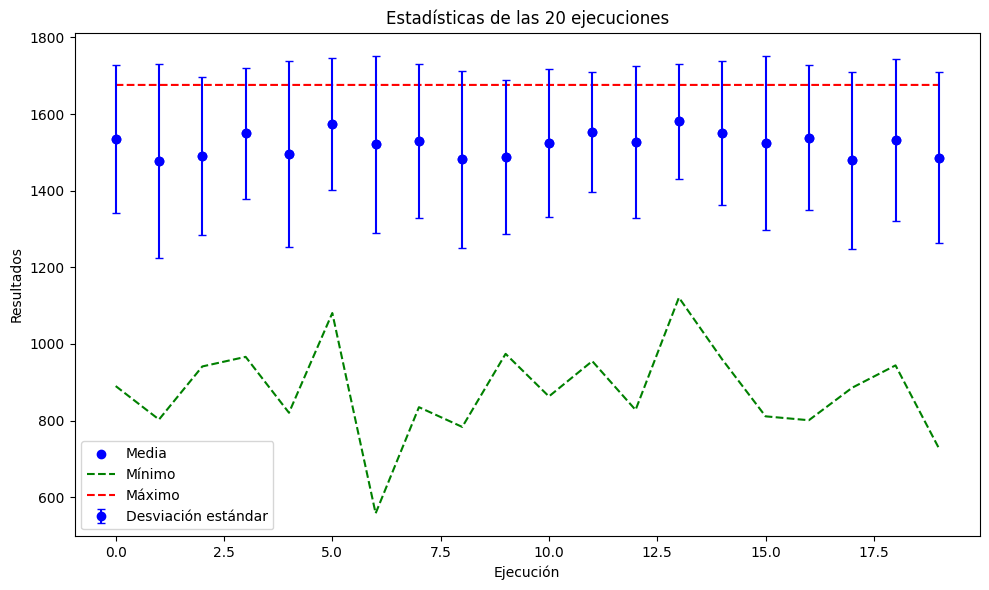

######## Resultados promediados ########
      Mínima: 877.3560039644686
      Media: 1521.916242454475
      Máxima: 1675.9314615150724
      Desviación estándar: 203.55041268205474


In [34]:
# Crear el gráfico
plt.figure(figsize=(10, 6))

# Graficar medias
plt.scatter(df_stats.index, df_stats['media_apt'], color='blue', label='Media')

# Graficar mínimos y máximos
plt.plot(df_stats.index, df_stats['min_apt'], linestyle='--', color='green', label='Mínimo')
plt.plot(df_stats.index, df_stats['max_apt'], linestyle='--', color='red', label='Máximo')

# Graficar desviación estándar como barras de error
plt.errorbar(df_stats.index, df_stats['media_apt'], yerr=df_stats['std_apt'], fmt='o', color='blue', capsize=3, label='Desviación estándar')

# Presentación
plt.xlabel('Ejecución')
plt.ylabel('Resultados')
plt.title('Estadísticas de las 20 ejecuciones')
plt.legend()
plt.tight_layout()
plt.show()

print(f'''######## Resultados promediados ########
      Mínima: {df_stats['min_apt'].mean()}
      Media: {df_stats['media_apt'].mean()}
      Máxima: {df_stats['max_apt'].mean()}
      Desviación estándar: {df_stats['std_apt'].mean()}''')


### Punto 3
Reportar gráfica de convergencia. Eje x número de generaciones, eje y mediana de la mejor aptitud de cada generación.

In [35]:
# Definición de genes y algoritmo
Gen1 = Gen((-500,500),10)
Gen2 = Gen((-500,500),10)
se = SimpleEvolutionary(Gen1,Gen2)

In [36]:
N = 100
num_genero = 500
_ = se.optimize(f, N=N, num_gener=num_genero, export_name='point3')

Generación 1 ~%~%~%~%~%~%~%~%~%~%~%~%~%~%~%
 
        ##### Aptitud nominal #####
        Máximo: 1551.679263121363 | Media: 986.9319176708824 | Mínimo: 448.17616913780705
         
        ##### Recombinación #####
        Cruzas: 50 | Mutaciones: 94
         
        ##### Mejor individuo #####
        Genotipo: 0000110101011011000011110010001000010110001011001001101010111011000101110001010011000110 | Fenotipo: [-447.8292981893, 287.7760793312] | Aptitud: 1441.817088184012
        
Generación 2 ~%~%~%~%~%~%~%~%~%~%~%~%~%~%~%
 
        ##### Aptitud nominal #####
        Máximo: 1579.6312718603672 | Media: 1096.1037767694943 | Mínimo: 457.6135258564441
         
        ##### Recombinación #####
        Cruzas: 50 | Mutaciones: 90
         
        ##### Mejor individuo #####
        Genotipo: 0001001010000011111100110111100011111100000011001101001011011010101011101010101010110011 | Fenotipo: [-427.6740865353, 301.4780829355] | Aptitud: 1551.679263121363
        
Generación 3 ~%~%~%~%

In [37]:
stats = pd.read_csv(f'log/estadisticas/stats_{"point3"}.csv', index_col=0).T
cols_float = ['min_apt', 'max_apt', 'media_apt', 'std_apt']
df_stats[cols_float] = df_stats[cols_float].astype(float)

In [ ]:
# Crear el gráfico
plt.figure(figsize=(10, 6))

# Graficar medias
plt.scatter(df_stats.index, df_stats['media_apt'], color='blue', label='Media')

# Graficar mínimos y máximos
plt.plot(df_stats.index, df_stats['min_apt'], linestyle='--', color='green', label='Mínimo')
plt.plot(df_stats.index, df_stats['max_apt'], linestyle='--', color='red', label='Máximo')

# Graficar desviación estándar como barras de error
plt.errorbar(df_stats.index, df_stats['media_apt'], yerr=df_stats['std_apt'], fmt='o', color='blue', capsize=3, label='Desviación estándar')

# Presentación
plt.xlabel('Ejecución')
plt.ylabel('Resultados')
plt.title('Estadísticas de las 20 ejecuciones')
plt.legend()
plt.tight_layout()
plt.show()

print(f'''######## Resultados promediados ########
      Mínima: {df_stats['min_apt'].mean()}
      Media: {df_stats['media_apt'].mean()}
      Máxima: {df_stats['max_apt'].mean()}
      Desviación estándar: {df_stats['std_apt'].mean()}''')


# Test

In [79]:
# arbitrary number of genes
Gen1 = Gen((-500,500),8)
Gen2 = Gen((-500,500),8)
CromA = Cromosoma(Gen1,Gen2)

In [82]:
se = SimpleEvolutionary(Gen1,Gen2)
se.optimize(f,100,1000,fast=True)

Generación 1 ~%~%~%~%~%~%~%~%~%~%~%~%~%~%~%
 
        ##### Aptitud nominal #####
        Máximo: 1495.8493296761048 | Media: 957.0031549592009 | Mínimo: 331.3530466162657
         
        ##### Recombinación #####
        Cruzas: 50 | Mutaciones: 96
         
        ##### Mejor individuo #####
        Genotipo: 00011110000101001100100110011110101110001011001111111101111001001110001101 | Fenotipo: [-382.49530673, -412.1133917] | Aptitud: 1495.8493296761048
        
Generación 2 ~%~%~%~%~%~%~%~%~%~%~%~%~%~%~%
 
        ##### Aptitud nominal #####
        Máximo: 1641.5663715247667 | Media: 993.334408023099 | Mínimo: 331.35304564801436
         
        ##### Recombinación #####
        Cruzas: 50 | Mutaciones: 107
         
        ##### Mejor individuo #####
        Genotipo: 00011110000101001100100110011110101110001011001111111101111001001110001101 | Fenotipo: [-382.49530673, -412.1133917] | Aptitud: 1495.8493296761048
        
Generación 3 ~%~%~%~%~%~%~%~%~%~%~%~%~%~%~%
 
        #

{'cromosoma': '00010100010000000011001100111110010000001010000111010111010000011011011010',
 'apt': 1675.9308885094504}

In [753]:
N = 30
crom_len = CromA.crom_len
pp = np.random.binomial(n=1, p=0.5, size=(N,crom_len))

pp = pp.astype(str)
pp_bin = np.array([''.join(xi) for xi in pp])

In [754]:
_realrep = np.array([CromA.representacion(cr,mode='decode') for cr in pp_bin])
__binrep = np.array([CromA.representacion(cr,mode='code') for cr in _realrep])

for i,j in zip(pp_bin,__binrep):
    if i!=j:
        print('i: ', CromA.representacion(i,mode='decode'), i)
        print('j: ', CromA.representacion(j,mode='decode'), j)
        print('#####################')

i:  [-119.61948, 265.793] 01100001011000001001111000111000100000010101111
j:  [380.38552, -233.707] 11100001011000001111001000001000100001010111100
#####################
i:  [-285.75998, 364.713] 00110110110110000110111100111011101010111011100
j:  [214.24503, -134.787] 10110110110110001100001100001011101011111101001
#####################
i:  [-210.54781, 270.335] 01001010000110011000100111111000101001101001010
j:  [289.4572, -229.165] 11001010000110011101110111101000101010101010111
#####################
i:  [442.28939, -206.819] 11110001001110011110000010001001011000011011110
j:  [-57.70561, 293.682] 01110001001110100011010010011001011001011101011
#####################
i:  [-294.34202, 44.812] 00110100101001100000000001110001011011110001100
j:  [205.66299, -454.688] 10110100101001100101010001000001011100110011001
#####################
i:  [398.79351, -491.776] 11100110000101110101010011000000010000110101111
j:  [-101.20149, 8.725] 01100110000101111010100011010000010001110111100
#######

In [755]:
_realrep
   

array([[-119.61948,  265.793  ],
       [-285.75998,  364.713  ],
       [-210.54781,  270.335  ],
       [ 442.28939, -206.819  ],
       [-294.34202,   44.812  ],
       [ 398.79351, -491.776  ],
       [  31.08428, -438.737  ],
       [ 455.58109,  340.573  ],
       [ 483.15024, -436.13   ],
       [-332.47894,  340.227  ],
       [-110.93287, -405.422  ],
       [-314.32529,  -63.168  ],
       [  87.29124, -309.644  ],
       [ 289.88194,  180.216  ],
       [-471.46873, -329.153  ],
       [  80.92293,  -32.307  ],
       [ 438.26174,  478.579  ],
       [ 432.6314 , -341.813  ],
       [ -10.54553,   86.731  ],
       [ 171.64204, -178.876  ],
       [-228.30143,  474.033  ],
       [ 141.67061, -468.806  ],
       [-345.86044, -316.615  ],
       [ 454.47862,  359.025  ],
       [-404.24997,  443.222  ],
       [ 250.44466,  202.735  ],
       [ 400.41406,  485.604  ],
       [-247.10562,  417.547  ],
       [ 340.01288, -267.555  ],
       [-166.88131, -409.507  ]])

### Test 2

In [30]:
se.poblacion = se.random_generator(1000,CromA.crom_len)

In [32]:
pars = se.ruleta()
mothers = pars.iloc[1::2]
fathers = pars.iloc[::2]

In [33]:
# Generación de hijos
cross = np.array(np.vectorize(se.cruza)
                (mothers['cromosoma'],fathers['cromosoma'])
                ).reshape(-1,1)
n_muts, mutacion = np.vectorize(se.mutacion)(cross)